In [21]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, classification_report
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
import json
import pickle
import time
import wandb
import re

In [22]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "SVM"}
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [23]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [24]:
config = wandb.config

config.maxlen = 1000
config.vocab_size = 30000
config.embedding_dims = 200
config.epochs = 7
config.hidden_dims = 200
config.batch_size = 32

In [25]:
train_set = pd.read_csv('../datasets/quotes/quotes_train.csv', encoding="latin1")
test_set = pd.read_csv('../datasets/quotes/quotes_test.csv', encoding="latin1")

train_set.head()

,text,label,level
0,always be yourself express yourself have fai...,1,A2
1,i passionately believe home cooking has vast b...,1,A2
2,it is the attention we give to bad situations ...,0,A1
3,looking back i wonder if mom saw it in my eye...,1,A2
4,since beginners can only remain in contact wit...,2,B1


In [26]:
data = pd.concat([train_set,test_set], axis=0)

data.reset_index(inplace=True)

len(data.index)

20913

In [27]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["text"]:
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining
    text = " ".join(text)

    cleanedData.append(text)

In [28]:
vectorizer = TfidfVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [29]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["label"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15684, 10000)
(5229, 10000)
(15684,)
(5229,)


In [30]:
from sklearn.svm import SVC
start_time = time.time()
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
grid.fit(x_train, y_train)

model = grid.best_estimator_

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  18.5s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  18.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  18.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  18.3s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  18.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.4s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=  18.2s
[CV] END ......................C=1, gamma=0.1, 

In [31]:
from sklearn.metrics import accuracy_score,confusion_matrix
predictions = model.predict(x_test)
print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 62.70797475616753%


In [32]:
print(predictions)
print(y_test)

[2 4 0 ... 1 3 3]
[2 4 0 ... 1 3 3]


Accuracy: 0.627
Accuracy for label A1: 0.836
Accuracy for label A2: 0.572
Accuracy for label B1: 0.368
Accuracy for label B2: 0.729
Accuracy for label C1: 0.079
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.75      0.84      0.79      1678
          A2       0.57      0.57      0.57      1445
          B1       0.48      0.37      0.42       918
          B2       0.59      0.73      0.65       954
          C1       0.53      0.08      0.14       227
          C2       0.00      0.00      0.00         7

    accuracy                           0.63      5229
   macro avg       0.49      0.43      0.43      5229
weighted avg       0.61      0.63      0.61      5229


Confusion Matrix:
[[1402  250   15   11    0    0]
 [ 414  826  162   43    0    0]
 [  31  331  338  217    1    0]
 [  13   46  185  695   15    0]
 [   0    4    9  196   18    0]
 [   0    0    0    7    0    0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

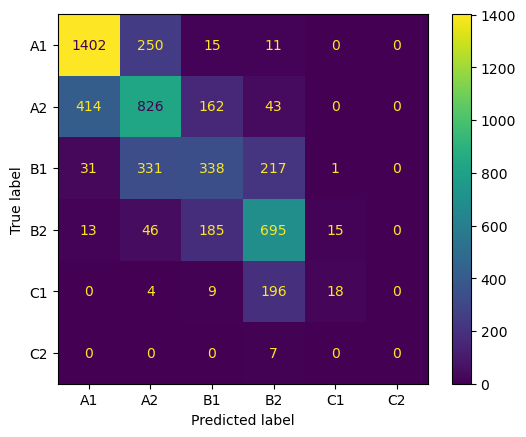

In [33]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = predictions

y_true = y_test

def map_func(x):
    return x if str(x).isnumeric() else label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train_set['level'], test_set['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [34]:
wandb.finish()